In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Tree-Based Models

Tree-based models are simple yet widely used machine learning models that partition the input space into cuboid regions, where each region is associated with a simple model (e.g., a constant value). These models are interpretable, making them popular in fields like medical diagnosis. In this notebook, we focus on **Classification and Regression Trees (CART)**, introduced by Breiman et al. (1984).

## Recursive Binary Partitioning

The input space is divided into regions using axis-aligned boundaries. For example:

1. Split the space at $x_1 \leq \theta_1$.
2. Further split $x_1 \leq \theta_1$ at $x_2 \leq \theta_2$.
3. Similarly, split $x_1 > \theta_1$ at $x_2 \leq \theta_3$.

This recursive subdivision can be represented as a **binary tree** where each node defines a split based on one input variable and a threshold parameter, $\theta$.

### Illustration

#### Partitioned Input Space
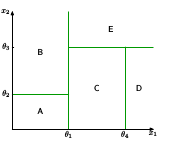

Fig.5 Illustration of a two-dimensional in- put space that has been partitioned into ﬁve regions using axis-aligned boundaries.

#### Corresponding Binary Tree

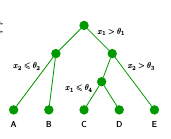

Fig.6 Binary tree corresponding to the partitioning of input space shown in Fig.5.

## Model Prediction

For any new input $\mathbf{x}$:
1. Traverse the binary tree starting at the root node.
2. Follow the branches based on the decision criteria at each node.
3. Arrive at a leaf node that corresponds to a specific region of the input space.
4. Predict the target variable based on the model for that region.

For **classification**, assign a class to each region.  
For **regression**, assign a constant value (the mean of target values in that region).

## Learning Decision Trees

To construct a decision tree:
1. **Split Criterion**: Determine the input variable and threshold to split at each node.
2. **Recursive Growth**: Grow the tree by splitting regions until stopping criteria are met.
3. **Pruning**: Remove unnecessary nodes to balance complexity and accuracy.

### Regression Case

Given:
- Training data: $\{\mathbf{x}_n, t_n\}_{n=1}^N$, where $t_n$ are continuous labels.
- Partitioned input space.

The **optimal prediction** for region $R_\tau$ is:
$$
y_\tau = \frac{1}{N_\tau} \sum_{\mathbf{x}_n \in R_\tau} t_n
$$
where $N_\tau$ is the number of data points in $R_\tau$.

The **residual sum-of-squares error** for region $R_\tau$ is:
$$
Q_\tau(T) = \sum_{\mathbf{x}_n \in R_\tau} \left(t_n - y_\tau\right)^2
$$

### Tree Growth Strategy

1. Start with a root node representing the entire input space.
2. **Greedy Optimization**:
   - For each region, split on all variables and thresholds.
   - Compute the reduction in residual sum-of-squares error.
   - Choose the split that minimizes the residual error.

### Stopping Criteria

Stop adding nodes when:
- The reduction in residual error falls below a threshold.
- The number of data points in a region is below a threshold.

Alternatively:
- Grow a large tree and prune unnecessary nodes.

### Pruning

Define the **cost function**:
$$
C(T) = \sum_{\tau=1}^{|T|} Q_\tau(T) + \lambda |T|
$$
where:
- $|T|$ is the number of leaf nodes in tree $T$.
- $\lambda$ is a regularization parameter balancing error and complexity.

**Optimal tree** is found by minimizing $C(T)$ over subtrees of $T_0$ (the fully grown tree). Cross-validation is used to select $\lambda$.

## Classification Case

For classification problems:
1. Replace the sum-of-squares error with an appropriate measure (e.g., Gini index, entropy).
2. Grow and prune the tree using similar methods.

### Summary

Tree-based models:
- Partition input space into interpretable regions.
- Are easy to implement and understand.
- Can be adapted for classification and regression tasks.

The balance between accuracy and complexity is achieved through pruning and regularization.


In [2]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index  # Index of the feature to split on
        self.threshold = threshold          # Threshold value for splitting
        self.left = left                    # Left subtree
        self.right = right                  # Right subtree
        self.value = value                  # Predicted value for leaf nodes

class CART:
    def __init__(self, min_samples_split=2, max_depth=float("inf")):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def predict(self, X):
        return [self._traverse_tree(x, self.root) for x in X]

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = len(y), len(X[0])

        # Stop if conditions are met
        if n_samples < self.min_samples_split or depth >= self.max_depth or len(set(y)) == 1:
            leaf_value = self._calculate_leaf_value(y)
            return Node(value=leaf_value)

        # Find the best split
        best_split = self._find_best_split(X, y, n_features)
        if not best_split:
            leaf_value = self._calculate_leaf_value(y)
            return Node(value=leaf_value)

        # Recursively build the tree
        left_subtree = self._build_tree(best_split["X_left"], best_split["y_left"], depth + 1)
        right_subtree = self._build_tree(best_split["X_right"], best_split["y_right"], depth + 1)
        
        return Node(feature_index=best_split["feature_index"],
                    threshold=best_split["threshold"],
                    left=left_subtree, right=right_subtree)

    def _find_best_split(self, X, y, n_features):
        best_split = {}
        min_error = float("inf")

        for feature_index in range(n_features):
            thresholds = set([x[feature_index] for x in X])
            for threshold in thresholds:
                X_left, y_left, X_right, y_right = self._split(X, y, feature_index, threshold)
                if len(X_left) > 0 and len(X_right) > 0:
                    error = self._calculate_error(y_left, y_right)
                    if error < min_error:
                        min_error = error
                        best_split = {
                            "feature_index": feature_index,
                            "threshold": threshold,
                            "X_left": X_left,
                            "y_left": y_left,
                            "X_right": X_right,
                            "y_right": y_right
                        }
        return best_split if best_split else None

    def _split(self, X, y, feature_index, threshold):
        X_left, y_left, X_right, y_right = [], [], [], []
        for i, row in enumerate(X):
            if row[feature_index] <= threshold:
                X_left.append(row)
                y_left.append(y[i])
            else:
                X_right.append(row)
                y_right.append(y[i])
        return X_left, y_left, X_right, y_right

    def _calculate_error(self, y_left, y_right):
        left_error = sum((yi - sum(y_left) / len(y_left)) ** 2 for yi in y_left) if y_left else 0
        right_error = sum((yi - sum(y_right) / len(y_right)) ** 2 for yi in y_right) if y_right else 0
        return left_error + right_error

    def _calculate_leaf_value(self, y):
        return sum(y) / len(y)

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

# Example Usage
if __name__ == "__main__":
    # Training data
    X_train = [
        [2.771244718, 1.784783929],
        [1.728571309, 1.169761413],
        [3.678319846, 2.81281357],
        [3.961043357, 2.61995032],
        [2.999208922, 2.209014212],
        [7.497545867, 3.162953546],
        [9.00220326, 3.339047188],
        [7.444542326, 0.476683375],
        [10.12493903, 3.234550982],
        [6.642287351, 3.319983761]
    ]
    y_train = [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]

    # Initialize and train CART
    cart = CART(min_samples_split=2, max_depth=3)
    cart.fit(X_train, y_train)

    # Test data
    X_test = [
        [1.5, 1.7],
        [8.0, 3.0]
    ]
    predictions = cart.predict(X_test)

    print("Predictions:", predictions)


Predictions: [1.0, 0.0]


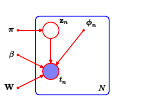

Fig.7 Probabilistic directed graph representing a mixture of linear regression models, deﬁned by (14.35).

## Mixtures of Linear Regression Models

In this notebook, we explore the probabilistic framework of mixtures of linear regression models. We model the conditional distribution using a mixture of conditional Gaussian distributions, and employ the **Expectation-Maximization (EM)** algorithm to optimize the parameters.

---

## 1. Overview

The **Mixture of Linear Regression Models** is an extension of Gaussian Mixture Models to conditional distributions. The model is represented as:

$$
p(t | \theta) = \sum_{k=1}^{K} \pi_k \mathcal{N}(t | w_k^T \phi, \beta^{-1})
$$

where:
- $K$ is the number of mixture components.
- $\pi_k$ are the mixing coefficients such that $\sum_{k=1}^K \pi_k = 1$.
- $w_k$ are the weights of the $k$-th linear regression model.
- $\beta$ is the precision (inverse variance) of the noise.

### Log-Likelihood
The log-likelihood of the data is given by:

$$
\ln p(t | \theta) = \sum_{n=1}^N \ln \left( \sum_{k=1}^K \pi_k \mathcal{N}(t_n | w_k^T \phi_n, \beta^{-1}) \right)
$$

We maximize this using the **Expectation-Maximization (EM)** algorithm.

---

## 2. EM Algorithm for Mixtures of Linear Regression

### E-Step:
Estimate the responsibilities $r_{nk}$ (the probability of data point $n$ belonging to component $k$):

$$
r_{nk} = \frac{\pi_k \mathcal{N}(t_n | w_k^T \phi_n, \beta^{-1})}{\sum_{j=1}^K \pi_j \mathcal{N}(t_n | w_j^T \phi_n, \beta^{-1})}
$$

### M-Step:
Update the parameters:

#### Mixing Coefficients:
$$
\pi_k = \frac{\sum_{n=1}^N r_{nk}}{N}
$$

#### Regression Weights:
$$
w_k = \left(\sum_{n=1}^N r_{nk} \phi_n \phi_n^T \right)^{-1} \left(\sum_{n=1}^N r_{nk} \phi_n t_n \right)
$$

#### Precision (Inverse Variance):
$$
\beta = \frac{1}{N} \sum_{n=1}^N \sum_{k=1}^K r_{nk} \left(t_n - w_k^T \phi_n\right)^2
$$

---



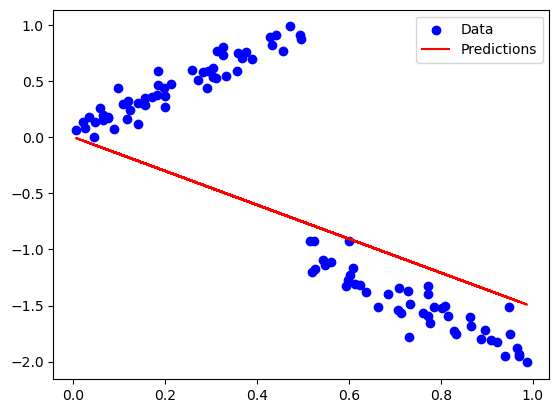

In [5]:
## 3. Implementation


import numpy as np

class MixtureOfLinearRegression:
    def __init__(self, n_components, max_iter=100, tol=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def _initialize_parameters(self, X, y):
        N, D = X.shape
        self.weights = np.random.rand(self.n_components, D)
        self.mixing_coefficients = np.ones(self.n_components) / self.n_components
        self.beta = 1.0

    def _e_step(self, X, y):
        N, _ = X.shape
        responsibilities = np.zeros((N, self.n_components))

        for k in range(self.n_components):
            mean_k = X @ self.weights[k]
            var_k = 1 / self.beta
            responsibilities[:, k] = self.mixing_coefficients[k] * np.exp(-0.5 * ((y - mean_k)**2) / var_k) / np.sqrt(2 * np.pi * var_k)

        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities

    def _m_step(self, X, y, responsibilities):
        N, D = X.shape

        for k in range(self.n_components):
            r_k = responsibilities[:, k]
            sum_r_k = r_k.sum()

            # Update mixing coefficients
            self.mixing_coefficients[k] = sum_r_k / N

            # Update weights
            weighted_X = (r_k[:, np.newaxis] * X).T
            self.weights[k] = np.linalg.solve(weighted_X @ X, weighted_X @ y)

            # Update beta
        self.beta = sum(
            responsibilities[:, k] * (y - X @ self.weights[k]) ** 2
            for k in range(self.n_components)
        ).sum() / N

    def fit(self, X, y):
        self._initialize_parameters(X, y)

        log_likelihood = -np.inf
        for iteration in range(self.max_iter):
            responsibilities = self._e_step(X, y)
            self._m_step(X, y, responsibilities)

            # Log likelihood
            new_log_likelihood = np.sum(
                np.log(np.sum(
                    [self.mixing_coefficients[k] * np.exp(-0.5 * ((y - X @ self.weights[k]) ** 2) * self.beta) / np.sqrt(2 * np.pi / self.beta)
                     for k in range(self.n_components)],
                    axis=0
                ))
            )

            if np.abs(new_log_likelihood - log_likelihood) < self.tol:
                break

            log_likelihood = new_log_likelihood

    def predict(self, X):
        return np.sum([self.mixing_coefficients[k] * (X @ self.weights[k]) for k in range(self.n_components)], axis=0)


## 4. Example Usage


# Generate synthetic data
np.random.seed(42)
X = np.random.rand(100, 1)
y = np.where(X < 0.5, 2 * X + np.random.randn(100, 1) * 0.1, -2 * X + np.random.randn(100, 1) * 0.1).flatten()

# Fit mixture model
model = MixtureOfLinearRegression(n_components=2)
model.fit(X, y)

# Predict
predictions = model.predict(X)

# Plot
import matplotlib.pyplot as plt
plt.scatter(X, y, color="blue", label="Data")
plt.plot(X, predictions, color="red", label="Predictions")
plt.legend()
plt.show()





### Mixtures of Linear Regression Models with the EM Algorithm


## Mixtures of Linear Regression Models with the EM Algorithm

## Introduction

In this notebook, we derive and implement a probabilistic **Mixture of Linear Regression Models** using the Expectation-Maximization (EM) algorithm. This framework builds on the Gaussian Mixture Model (GMM) by incorporating linear regression into each mixture component. The process involves alternating between the E-step and M-step to optimize the parameters of the model.

---

## Theoretical Formulation

We have $K$ linear regression models, each represented by:

$$
p(t | \phi_n, w_k, \beta) = N(t | w_k^T \phi_n, \beta^{-1})
$$

where $\phi_n$ is the input for data point $n$, $w_k$ are the weights for the $k^{th}$ linear model, and $\beta$ is the precision (inverse of variance). The mixing coefficients $\pi_k$ satisfy:

$$
\sum_{k=1}^K \pi_k = 1
$$

The mixture model is given by:

$$
p(t | \phi_n, \theta) = \sum_{k=1}^K \pi_k N(t | w_k^T \phi_n, \beta^{-1})
$$

where $\theta = \{w_k, \pi_k, \beta\}$.

### EM Algorithm

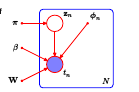

Fig.7 Probabilistic directed graph representing a mixture of linear regression models, deﬁned by (14.35).

#### E-step

In the E-step, we compute the responsibilities $\gamma_{nk}$:

$$
\gamma_{nk} = \frac{\pi_k N(t_n | w_k^T \phi_n, \beta^{-1})}{\sum_{j=1}^K \pi_j N(t_n | w_j^T \phi_n, \beta^{-1})}
$$

#### M-step

We update the parameters $\pi_k$, $w_k$, and $\beta$.

1. **Mixing Coefficients**:
$$
\pi_k = \frac{1}{N} \sum_{n=1}^N \gamma_{nk}
$$

2. **Regression Weights**:
$$
w_k = (\Phi^T \Gamma_k \Phi)^{-1} \Phi^T \Gamma_k t
$$

where $\Gamma_k$ is a diagonal matrix with $\gamma_{nk}$ along its diagonal.

3. **Precision**:
$$
\beta = \frac{\sum_{k=1}^K \sum_{n=1}^N \gamma_{nk} (t_n - w_k^T \phi_n)^2}{\sum_{k=1}^K \sum_{n=1}^N \gamma_{nk}}$$





In [6]:
## Implementation


import numpy as np

class MixtureOfLinearRegression:
    def __init__(self, n_components, n_features, max_iter=100, tol=1e-4):
        self.n_components = n_components
        self.n_features = n_features
        self.max_iter = max_iter
        self.tol = tol

        # Initialize parameters
        self.weights = np.random.randn(n_components, n_features)
        self.mixing_coeffs = np.full(n_components, 1 / n_components)
        self.precision = 1.0

    def _e_step(self, X, y):
        responsibilities = np.zeros((X.shape[0], self.n_components))

        for k in range(self.n_components):
            residuals = y - X @ self.weights[k]
            responsibilities[:, k] = (
                self.mixing_coeffs[k]
                * np.exp(-0.5 * self.precision * residuals**2)
            )

        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities

    def _m_step(self, X, y, responsibilities):
        N_k = responsibilities.sum(axis=0)
        self.mixing_coeffs = N_k / len(y)

        for k in range(self.n_components):
            Gamma_k = np.diag(responsibilities[:, k])
            self.weights[k] = (
                np.linalg.inv(X.T @ Gamma_k @ X) @ X.T @ Gamma_k @ y
            )

        residual_sum = 0
        for k in range(self.n_components):
            residuals = y - X @ self.weights[k]
            residual_sum += (responsibilities[:, k] * residuals**2).sum()

        self.precision = len(y) / residual_sum

    def fit(self, X, y):
        for iteration in range(self.max_iter):
            responsibilities = self._e_step(X, y)
            self._m_step(X, y, responsibilities)

            log_likelihood = self._compute_log_likelihood(X, y)
            if iteration > 0 and np.abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
            prev_log_likelihood = log_likelihood

    def _compute_log_likelihood(self, X, y):
        log_likelihood = 0
        for k in range(self.n_components):
            residuals = y - X @ self.weights[k]
            log_likelihood += np.sum(
                np.log(self.mixing_coeffs[k])
                - 0.5 * self.precision * residuals**2
            )
        return log_likelihood

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for k in range(self.n_components):
            predictions += self.mixing_coeffs[k] * (X @ self.weights[k])
        return predictions

# Example usage
X = np.random.randn(100, 2)
y = X @ np.array([2.0, -1.0]) + np.random.randn(100)

model = MixtureOfLinearRegression(n_components=2, n_features=2)
model.fit(X, y)
print("Weights:", model.weights)
print("Mixing Coefficients:", model.mixing_coeffs)


Weights: [[ 1.88995262 -0.96383831]
 [ 1.89136959 -0.96790256]]
Mixing Coefficients: [0.11235255 0.88764745]
